<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting/blob/main/Sector_Indices_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

gen_output = 0

Run date time (IST): 2024-02-09 19:24:39


In [11]:
# install libraries
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

In [12]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib
yfin.pdr_override()
import pandas_ta as ta

from google.colab import data_table

In [13]:
# set start and end date
start_date = (datetime.date.today() + datetime.timedelta(days=-10*365)).strftime('%Y-%m-%d')
start1_date = (datetime.date.today() + datetime.timedelta(days=-1*365)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')

In [14]:
# fetch nse indices scrips

import pandas as pd
import numpy as np

df_nse_sectors = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/NSE_Sectors_Indices.csv')

In [15]:
sectors = df_nse_sectors['Sector'].unique()
df_sectors = pd.DataFrame()
for sector in sectors:
  stocks = df_nse_sectors[df_nse_sectors['Sector'] == sector]['Symbol'].values
  df_sector = pd.DataFrame()
  tweight = 0
  for stock in stocks:
    stock_df = yfin.Ticker(stock+'.NS').history(period='5y', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    col = ['Close']
    stock_df = stock_df[col]
    stock_df['Split'] = 1
    weight = df_nse_sectors[df_nse_sectors['Symbol'] == stock]['Weight'].values[0]
    tweight = sum(df_nse_sectors[df_nse_sectors['Sector'] == sector]['Weight'].values)
    if stock == 'NESTLEIND':
      stock_df.loc[stock_df.index < '2024-01-01', 'Split'] = 10
    #stock_df[stock] = (stock_df[col]*weight)/(tweight*stock_df['Split'].values[0])
    stock_df[stock] = stock_df['Close']/stock_df['Split']
    col = [stock]
    stock_df = stock_df[col]
    df_sector = pd.concat([df_sector, stock_df], axis=1)

  df_sector[sector] = df_sector[stocks].sum(axis=1)
  col = [sector]
  df_sector = df_sector[col]
  df_sectors = pd.concat([df_sectors, df_sector], axis=1)
df_sectors

,AUTO,BANKS,FINANCE,IT,FMCG,PHARMA,MEDIA,METAL,INFRA,CHEMICAL,CEMENT,DURABLES,JEWELLERY,TEXTILES
Date,,,,,,,,,,,,,,
2019-02-11 00:00:00+05:30,12958.960861,3650.545197,3323.412605,5605.711487,6006.120164,7397.550568,940.481716,782.777199,7832.506187,3662.071320,21566.903214,4191.614365,1715.693985,1849.275501
2019-02-12 00:00:00+05:30,12851.483047,3627.101868,3290.089211,5564.588593,5902.415663,7439.012604,940.874744,802.653286,7847.358898,3651.365601,21428.579239,4097.729050,1722.646446,1855.109420
2019-02-14 00:00:00+05:30,12683.275558,3587.026611,3271.471287,5533.242279,5807.549437,7423.857239,975.721119,805.628487,7860.885853,3600.771370,21233.457336,4042.175247,1688.289055,1822.482043
2019-02-15 00:00:00+05:30,12513.040848,3565.171631,3225.503956,5526.576233,5724.382893,7233.267120,945.731340,782.953808,7845.371754,3553.519089,21177.851974,3973.801804,1693.895920,1803.233629
2019-02-18 00:00:00+05:30,12380.709839,3553.870850,3198.797787,5439.703308,5730.814996,7168.088287,950.879742,776.259453,7781.044430,3510.512794,20789.855164,3944.393051,1674.464142,1772.623373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-05 00:00:00+05:30,27487.949768,5981.149963,9630.800217,14469.400177,12891.659485,17918.453247,3244.100014,5746.249985,26190.399765,18897.901398,42057.966797,18701.450226,4712.459198,5625.499893
2024-02-06 00:00:00+05:30,28063.399719,5957.800049,9583.999969,14810.199799,12825.905670,17990.588989,3264.800011,5816.250031,26391.249939,19229.049805,42853.723022,18874.999451,4727.553162,5747.949886
2024-02-07 00:00:00+05:30,28149.700134,5989.049927,9714.400146,14653.599792,12940.249939,18075.919434,3284.950008,5866.050079,26525.550278,19238.450165,43537.350891,18826.850189,4737.200012,5716.249992


In [16]:
def stock_prec_dev(stock_symbol):
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))

    stock_df = df_sectors[[stock_symbol]]
    stock_df.columns = ['Close']

    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    stock_df['Sector'] = stock_symbol

    stock_df['Close'] = round(stock_df['Close'],2)
    stock_df['Max'] = round(max(stock_df['Close']),2)
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start1_date)]
    stock_df['Min'] = round(min(stock_df['Close']),2)
    #stock_df['Gained%'] = round((stock_df['Close'] - stock_df['Min'])*100/stock_df['Min'],2)
    stock_df.ta.rsi(append=True)
    #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
    #stock_df['Close'] = round(stock_df['Close'],0)
    stock_df['RSI_14'] = round(stock_df['RSI_14'],0)
    stock_df['ATH%'] = round((stock_df['Max'] - stock_df['Close'])*100/stock_df['Close'],2)
    #stock_df['Sector'] = stock_symbol
    stock_df = stock_df.tail(1)
    return stock_df

In [17]:
df_final =  pd.DataFrame()
for sector in sectors:

  df_tmp = stock_prec_dev(sector)
  df_final = df_final.append(df_tmp)
# all sectors
df_final = df_final.sort_values(by = 'ATH%', ascending=False)
#data_table.DataTable(df_final, include_index=False)
df_final

,Close,200_SMA,Dev%_200,Sector,Max,Min,RSI_14,ATH%
Date,,,,,,,,
2024-02-09 00:00:00+05:30,3256.60,3142.0,3.65,MEDIA,3808.40,1273.44,48.0,16.94
2024-02-09 00:00:00+05:30,14688.45,12920.0,13.69,IT,16403.73,10640.54,55.0,11.68
2024-02-09 00:00:00+05:30,9563.40,9527.0,0.38,FINANCE,10627.62,6955.03,39.0,11.13
2024-02-09 00:00:00+05:30,5795.35,4781.0,21.22,METAL,6262.29,3173.78,64.0,8.06
2024-02-09 00:00:00+05:30,5933.40,5973.0,-0.66,BANKS,6391.75,5339.05,42.0,7.72
2024-02-09 00:00:00+05:30,4757.85,4289.0,10.93,JEWELLERY,5100.03,3349.89,43.0,7.19
2024-02-09 00:00:00+05:30,12760.50,11952.0,6.76,FMCG,13520.54,10043.42,45.0,5.96
2024-02-09 00:00:00+05:30,5652.05,5441.0,3.88,TEXTILES,5961.52,441.00,46.0,5.48
2024-02-09 00:00:00+05:30,18953.75,17650.0,7.39,CHEMICAL,19989.10,14703.47,49.0,5.46


<Axes: xlabel='Date'>

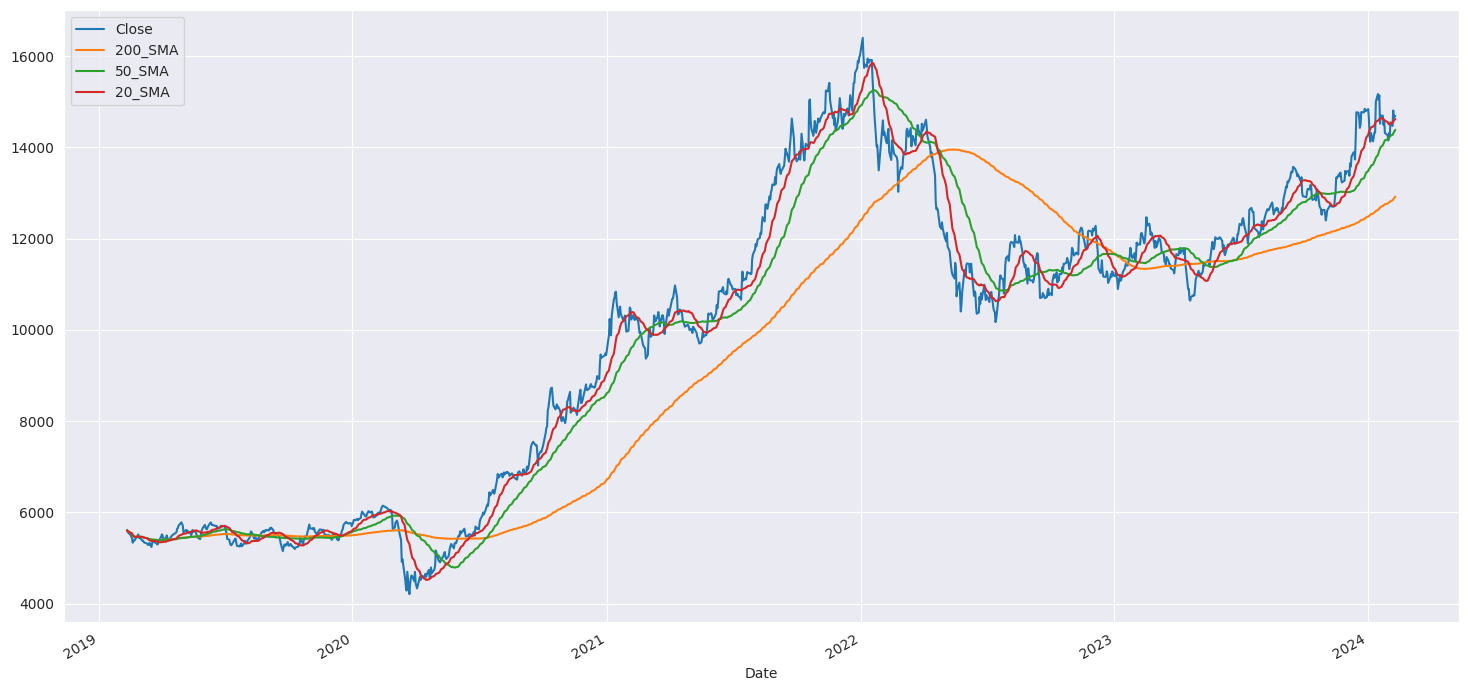

In [18]:
col = ['IT']
sector_df = df_sectors[col]
sector_df.columns = ['Close']
sector_df['200_SMA'] = round(sector_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
sector_df['50_SMA'] = round(sector_df['Close'].rolling(window = 50, min_periods = 1).mean(),0)
sector_df['20_SMA'] = round(sector_df['Close'].rolling(window = 20, min_periods = 1).mean(),0)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = sector_df.reset_index()
tmp_df.plot(x='Date', y=['Close','200_SMA','50_SMA','20_SMA'], figsize=(18,9))